In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [52]:
data = pd.read_csv('train.csv')
data.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [53]:
data.dtypes

,0
id,int64
Time_spent_Alone,float64
Stage_fear,object
Social_event_attendance,float64
Going_outside,float64
Drained_after_socializing,object
Friends_circle_size,float64
Post_frequency,float64
Personality,object


In [54]:
cat_cols = ['Stage_fear', 'Drained_after_socializing']
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']

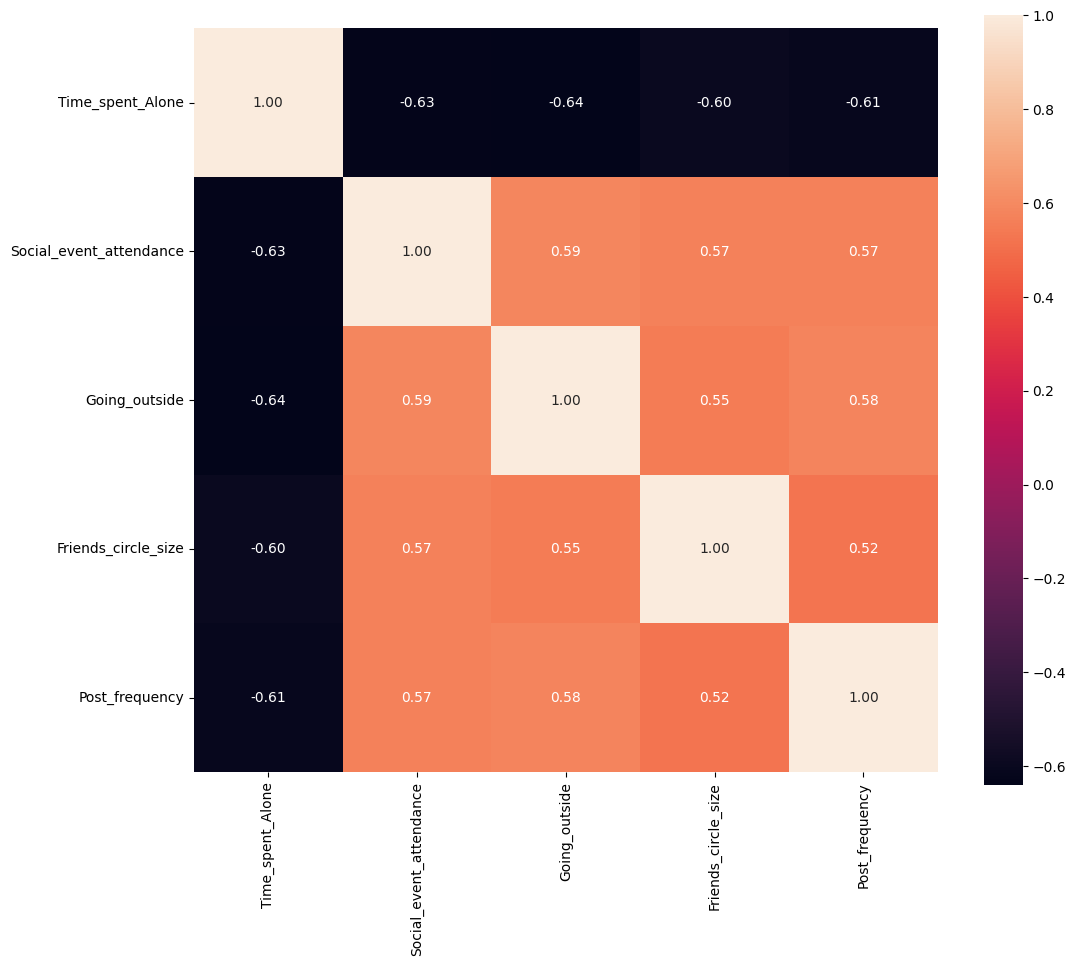

In [55]:
df = data[num_cols]

plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(),fmt='.2f', square = True, annot=True)
plt.show()

корреляция есть, но она не особо высокая, так что столбцы не удаляем

In [56]:
X = data.drop('Personality', axis=1)
y = data['Personality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
X_train.isna().sum()

,0
id,0
Time_spent_Alone,960
Stage_fear,1529
Social_event_attendance,945
Going_outside,1195
Drained_after_socializing,924
Friends_circle_size,843
Post_frequency,1008


In [88]:
cols_to_fix = ['Stage_fear', 'Drained_after_socializing']
cat_impute_values = {}

for col in cols_to_fix:
    mode_val = X_train[col].mode()[0]
    cat_impute_values[col] = mode_val
    X_train[col] = X_train[col].fillna(mode_val)

num_cols_to_fix = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
num_impute_values = {}

for col in num_cols_to_fix:
    med_val = X_train[col].median()
    num_impute_values[col] = med_val
    X_train[col] = X_train[col].fillna(med_val)

# пропуски заполнены :)
# !!!!!!! не залезаем в тест а то будет утечка данных
#в тесте пропуски тоже заполняем

X_test.fillna(value=cat_impute_values, inplace=True)
X_test.fillna(value=num_impute_values, inplace=True)

In [89]:
X_test.isna().sum()

,0
id,0
Time_spent_Alone,0
Stage_fear,0
Social_event_attendance,0
Going_outside,0
Drained_after_socializing,0
Friends_circle_size,0
Post_frequency,0


array([[<Axes: title={'center': 'Time_spent_Alone'}>,
        <Axes: title={'center': 'Social_event_attendance'}>],
       [<Axes: title={'center': 'Going_outside'}>,
        <Axes: title={'center': 'Friends_circle_size'}>],
       [<Axes: title={'center': 'Post_frequency'}>, <Axes: >]],
      dtype=object)

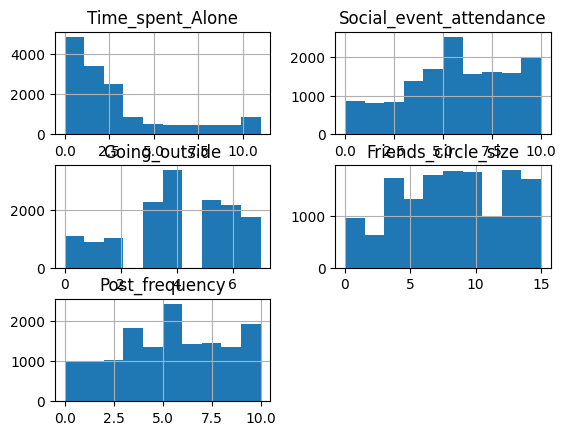

In [90]:
X_train[num_cols].hist()

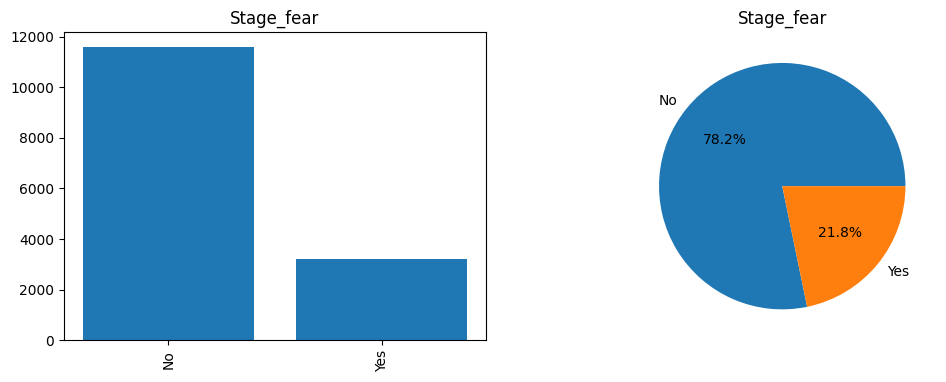

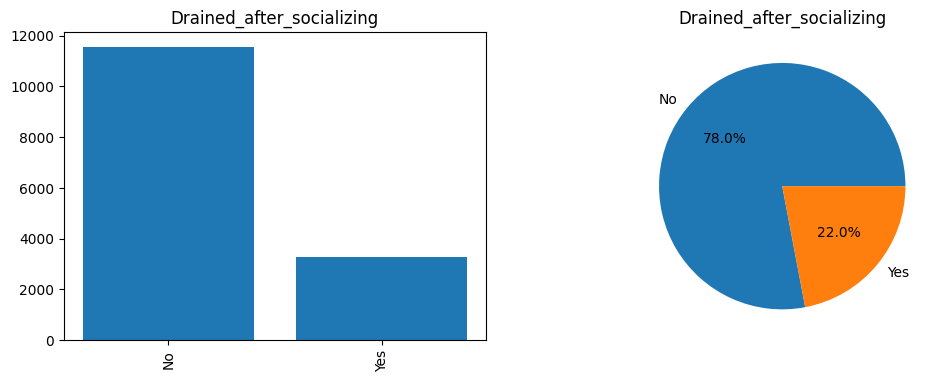

In [91]:
for col in cat_cols:
    counts = X_train[col].value_counts()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].bar(counts.index.astype(str), counts.values)
    ax[0].set_title(col)
    ax[0].tick_params(axis="x", rotation=90)

    ax[1].pie(counts.values, labels=counts.index.astype(str), autopct='%1.1f%%')
    ax[1].set_title(col)

    plt.show()

In [92]:
!pip install catboost

In [93]:
import catboost as cb
from sklearn.metrics import mean_squared_error

In [94]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("X_train:", X_train.shape)
print("y_train:", len(y_train_encoded))
print("X_test:", X_test.shape)
print("y_test:", len(y_test_encoded))

X_train: (14819, 8)
y_train: 14819
X_test: (3705, 8)
y_test: 3705


In [95]:
model = cb.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100
)

model.fit(
    X_train,
    y_train_encoded,
    cat_features = cat_cols,
    eval_set=(X_test, y_test_encoded)
)

0:	learn: 0.5446292	test: 0.5446653	best: 0.5446653 (0)	total: 12ms	remaining: 12s
100:	learn: 0.1121635	test: 0.1343837	best: 0.1335171 (39)	total: 1.22s	remaining: 10.8s
200:	learn: 0.0989239	test: 0.1366063	best: 0.1335171 (39)	total: 3.1s	remaining: 12.3s
300:	learn: 0.0889450	test: 0.1386717	best: 0.1335171 (39)	total: 5.24s	remaining: 12.2s
400:	learn: 0.0799301	test: 0.1411315	best: 0.1335171 (39)	total: 7.21s	remaining: 10.8s
500:	learn: 0.0723831	test: 0.1428843	best: 0.1335171 (39)	total: 8.72s	remaining: 8.69s
600:	learn: 0.0657789	test: 0.1456918	best: 0.1335171 (39)	total: 9.99s	remaining: 6.63s
700:	learn: 0.0595502	test: 0.1473689	best: 0.1335171 (39)	total: 11.1s	remaining: 4.73s
800:	learn: 0.0538870	test: 0.1497716	best: 0.1335171 (39)	total: 12.3s	remaining: 3.06s
900:	learn: 0.0495705	test: 0.1516940	best: 0.1335171 (39)	total: 13.9s	remaining: 1.53s
999:	learn: 0.0455347	test: 0.1534241	best: 0.1335171 (39)	total: 15.3s	remaining: 0us

bestTest = 0.1335170949
bestI

CatBoostClassifier(depth=6, iterations=1000, learning_rate=0.1, random_seed=42, verbose=100)

In [96]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9690


In [97]:
y_original = label_encoder.inverse_transform(y_pred)
y_original

array(['Extrovert', 'Extrovert', 'Extrovert', ..., 'Extrovert',
       'Extrovert', 'Extrovert'], dtype=object)

In [98]:
data_send = pd.read_csv('test.csv')
data_send.fillna(value=cat_impute_values, inplace=True)
data_send.fillna(value=num_impute_values, inplace=True)
ans = model.predict(data_send)
ans_cat = label_encoder.inverse_transform(ans)

In [99]:
subm = pd.read_csv('sample_submission.csv')

subm.head()

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Extrovert


In [100]:
subm['Personality'] = ans_cat

subm.to_csv('my_subm.csv', index=None)

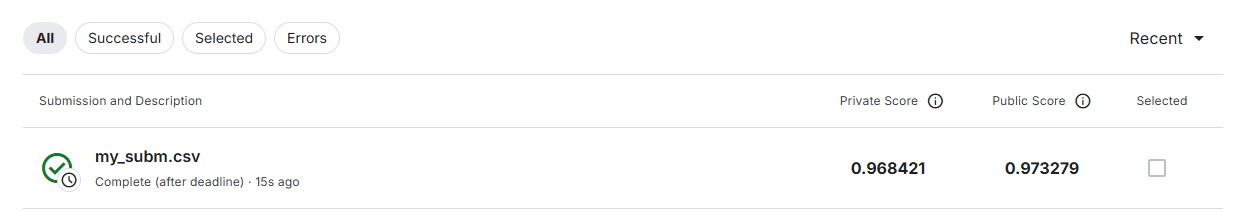

In [101]:
from IPython.display import Image
Image('/content/sc2.png')